In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# Load the dataset
file_path = 'C:/Users/admin/Desktop/malaria_cases.xlsx'
malaria_data = pd.read_excel(file_path)

# Display the first few rows
malaria_data.head()

,District,Period,Fever case tested for Malaria (RDT) - Positive
0,Bo District,January 2018,14082
1,Bo District,February 2018,13089
2,Bo District,March 2018,14408
3,Bo District,April 2018,15433
4,Bo District,May 2018,16956


In [3]:
# Convert the 'Period' column to datetime format and extract the relevant columns
malaria_data['Period'] = pd.to_datetime(malaria_data['Period'], format='%B %Y')
malaria_cases_ts = malaria_data[['Period', 'Fever case tested for Malaria (RDT) - Positive']].copy()

# Rename the columns
malaria_cases_ts.columns = ['Date', 'Positive_Cases']

# Set 'Date' as the index for the time series
malaria_cases_ts.set_index('Date', inplace=True)

# Display the cleaned data
malaria_cases_ts.head()

,Positive_Cases
Date,
2018-01-01,14082
2018-02-01,13089
2018-03-01,14408
2018-04-01,15433
2018-05-01,16956


C:\Users\admin\AppData\Local\Temp\ipykernel_17540\2618108107.py:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(frequencies[:n // 2], np.abs(fft_vals[:n // 2]), basefmt=" ", use_line_collection=True)


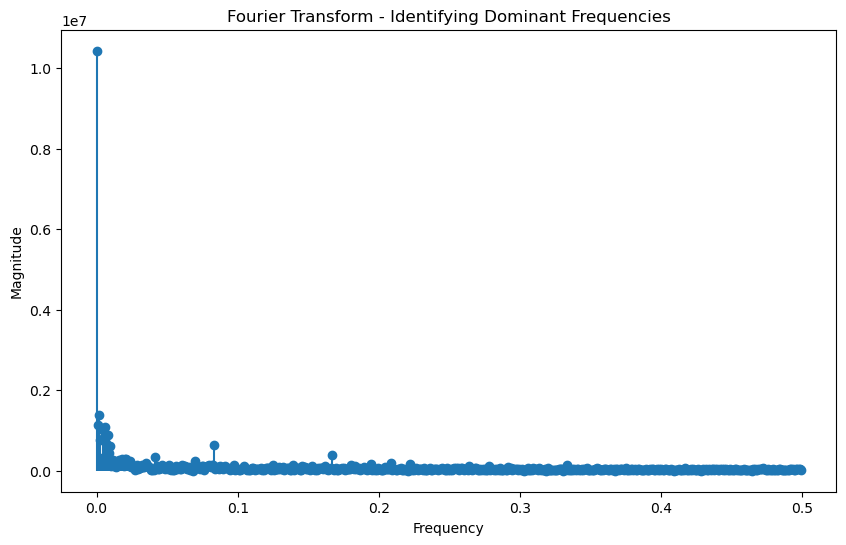

In [4]:
# Extracting time series values
positive_cases = malaria_cases_ts['Positive_Cases'].values
n = len(positive_cases)
t = np.arange(n)

# Fourier Transform to identify dominant frequencies
fft_vals = fftpack.fft(positive_cases)
frequencies = fftpack.fftfreq(n, d=1)

# Plot the magnitude of the FFT results to identify the dominant frequencies
plt.figure(figsize=(10, 6))
plt.stem(frequencies[:n // 2], np.abs(fft_vals[:n // 2]), basefmt=" ", use_line_collection=True)
plt.title('Fourier Transform - Identifying Dominant Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()


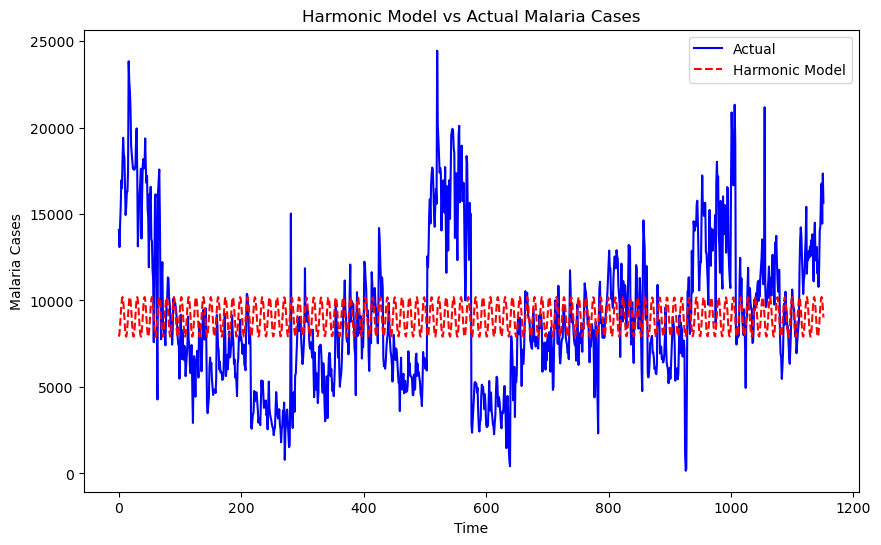

(4101.7979795453575, 3225.65663132401)

In [5]:
# Harmonic model function using the primary frequency (we used the first prominent frequency)
def harmonic_model(t, A1, B1, omega1, phi1, C):
    return A1 * np.cos(omega1 * t + phi1) + B1 * np.sin(omega1 * t + phi1) + C

# curve fitting to find the optimal parameters for the harmonic model
initial_guess = [np.std(positive_cases), np.std(positive_cases), 2 * np.pi / 12, 0, np.mean(positive_cases)]  # initial guesses
params, params_covariance = curve_fit(harmonic_model, t, positive_cases, p0=initial_guess)

# Predictions using the fitted model
harmonic_predictions = harmonic_model(t, *params)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(positive_cases, harmonic_predictions))
mae = mean_absolute_error(positive_cases, harmonic_predictions)

# Actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(t, positive_cases, label='Actual', color='blue')
plt.plot(t, harmonic_predictions, label='Harmonic Model', color='red', linestyle='--')
plt.title('Harmonic Model vs Actual Malaria Cases')
plt.xlabel('Time')
plt.ylabel('Malaria Cases')
plt.legend()
plt.show()

# Evaluation metrics
rmse, mae

In [6]:
# Check for missing values
missing_values = malaria_cases_ts.isnull().sum()

# New features: month and year
malaria_cases_ts['Month'] = malaria_cases_ts.index.month
malaria_cases_ts['Year'] = malaria_cases_ts.index.year

# Normalize the 'Positive_Cases' using Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
malaria_cases_ts['Positive_Cases_Norm'] = scaler.fit_transform(malaria_cases_ts[['Positive_Cases']])

# Display the preprocessed data
malaria_cases_ts.head(), missing_values

(            Positive_Cases  Month  Year  Positive_Cases_Norm
 Date                                                        
 2018-01-01           14082      1  2018             0.573405
 2018-02-01           13089      2  2018             0.532512
 2018-03-01           14408      3  2018             0.586830
 2018-04-01           15433      4  2018             0.629041
 2018-05-01           16956      5  2018             0.691760,
 Positive_Cases    0
 dtype: int64)

In [7]:
# Fit the harmonic model using the normalized data
normalized_cases = malaria_cases_ts['Positive_Cases_Norm'].values

# We reused the same harmonic model fitting method on the normalized data
params_norm, params_covariance_norm = curve_fit(harmonic_model, t, normalized_cases, p0=initial_guess)

# Predictions using the fitted harmonic model on normalized data
harmonic_predictions_norm = harmonic_model(t, *params_norm)

# Evaluation metrics for the normalized data
rmse_norm = np.sqrt(mean_squared_error(normalized_cases, harmonic_predictions_norm))
mae_norm = mean_absolute_error(normalized_cases, harmonic_predictions_norm)

# MAPE calculation
def mean_absolute_percentage_error_adjusted(y_true, y_pred): 
    non_zero_indices = y_true != 0  # Ignore zero values
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# MAPE
mape_norm = mean_absolute_percentage_error_adjusted(normalized_cases, harmonic_predictions_norm)

# MASE Calculation
def mean_absolute_scaled_error(y_true, y_pred):
    naive_forecast = np.roll(y_true, 1)
    naive_forecast[0] = y_true[0]  
    mae_naive = np.mean(np.abs(y_true - naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / mae_naive

# MASE
mase_norm = mean_absolute_scaled_error(normalized_cases, harmonic_predictions_norm)


# Evaluation metrics for the normalized data
print(f"MAE: {mae_norm:.4f}")
print(f"MAPE: {mape_norm:.4f}%")
print(f"RMSE: {rmse_norm:.4f}")
print(f"MASE: {mase_norm:.4f}")

MAE: 0.1328
MAPE: 59.0663%
RMSE: 0.1689
MASE: 2.7352


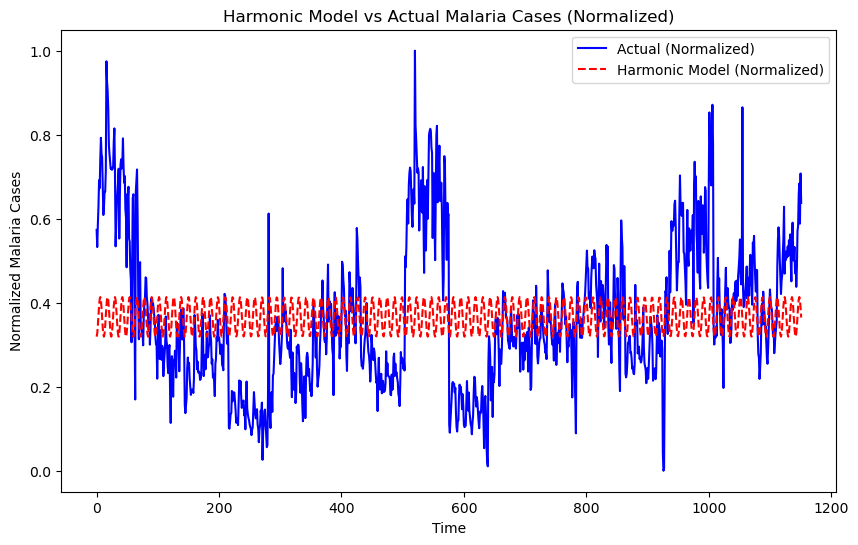

In [8]:
# Actual vs predicted values (normalized)
plt.figure(figsize=(10, 6))
plt.plot(t, normalized_cases, label='Actual (Normalized)', color='blue')
plt.plot(t, harmonic_predictions_norm, label='Harmonic Model (Normalized)', color='red', linestyle='--')
plt.title('Harmonic Model vs Actual Malaria Cases (Normalized)')
plt.xlabel('Time')
plt.ylabel('Normalized Malaria Cases')
plt.legend()
plt.show()

# FEATURE ENGINEERING

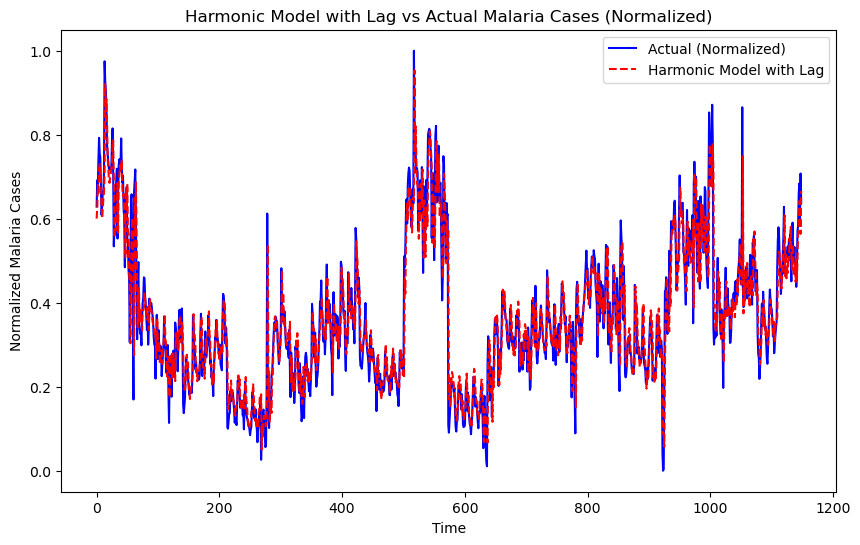

MAE: 0.0456
MAPE: 17.8973%
RMSE: 0.0679
MASE: 0.9392


In [9]:
# lag features: Lag of 1, 2, and 3 months for the normalized cases
malaria_cases_ts['Lag_1'] = malaria_cases_ts['Positive_Cases_Norm'].shift(1)
malaria_cases_ts['Lag_2'] = malaria_cases_ts['Positive_Cases_Norm'].shift(2)
malaria_cases_ts['Lag_3'] = malaria_cases_ts['Positive_Cases_Norm'].shift(3)

# Drop any rows with NaN values created due to lagging
malaria_cases_lagged = malaria_cases_ts.dropna()

# Re-define the variables for model fitting
t_lagged = np.arange(len(malaria_cases_lagged))
normalized_cases_lagged = malaria_cases_lagged['Positive_Cases_Norm'].values

# Refit the harmonic model with lagged features (we incorporate lag into the cosine/sine terms)
def harmonic_model_with_lag(t, A1, B1, omega1, phi1, C, lag_coeff_1, lag_coeff_2, lag_coeff_3):
    return (A1 * np.cos(omega1 * t + phi1) + B1 * np.sin(omega1 * t + phi1) + C
            + lag_coeff_1 * malaria_cases_lagged['Lag_1'].values
            + lag_coeff_2 * malaria_cases_lagged['Lag_2'].values
            + lag_coeff_3 * malaria_cases_lagged['Lag_3'].values)

# Initial guess for the new parameters
initial_guess_lagged = [np.std(normalized_cases_lagged), np.std(normalized_cases_lagged), 2 * np.pi / 12, 0, np.mean(normalized_cases_lagged), 0.5, 0.5, 0.5]

# Fit the model with lagged features
params_lagged, params_covariance_lagged = curve_fit(harmonic_model_with_lag, t_lagged, normalized_cases_lagged, p0=initial_guess_lagged)

# Predictions with the new model
harmonic_predictions_lagged = harmonic_model_with_lag(t_lagged, *params_lagged)

# Evaluation metrics for the lagged model
rmse_lagged = np.sqrt(mean_squared_error(normalized_cases_lagged, harmonic_predictions_lagged))
mae_lagged = mean_absolute_error(normalized_cases_lagged, harmonic_predictions_lagged)
mape_lagged = mean_absolute_percentage_error_adjusted(normalized_cases_lagged, harmonic_predictions_lagged)
mase_lagged = mean_absolute_scaled_error(normalized_cases_lagged, harmonic_predictions_lagged)

# Actual vs predicted values for the refined model
plt.figure(figsize=(10, 6))
plt.plot(t_lagged, normalized_cases_lagged, label='Actual (Normalized)', color='blue')
plt.plot(t_lagged, harmonic_predictions_lagged, label='Harmonic Model with Lag', color='red', linestyle='--')
plt.title('Harmonic Model with Lag vs Actual Malaria Cases (Normalized)')
plt.xlabel('Time')
plt.ylabel('Normalized Malaria Cases')
plt.legend()
plt.show()

# Evaluation metrics for the lagged model
print(f"MAE: {mae_lagged:.4f}")
print(f"MAPE: {mape_lagged:.4f}%")
print(f"RMSE: {rmse_lagged:.4f}")
print(f"MASE: {mase_lagged:.4f}")

# RESIDUAL ANALYSIS

In [11]:
def harmonic_model_with_lag(t, A1, B1, omega1, phi1, C, lag_coeff_1, lag_coeff_2, lag_coeff_3, lags=None):
    harmonic = A1 * np.cos(omega1 * t + phi1) + B1 * np.sin(omega1 * t + phi1) + C
    if lags is not None:
        lag_terms = (lag_coeff_1 * lags['Lag_1'] +
                     lag_coeff_2 * lags['Lag_2'] +
                     lag_coeff_3 * lags['Lag_3'])
        return harmonic + lag_terms
    return harmonic

# Fit the model
initial_guess_lagged = [np.std(normalized_cases_lagged), np.std(normalized_cases_lagged), 2 * np.pi / 12, 0, np.mean(normalized_cases_lagged), 0.5, 0.5, 0.5]
params_lagged, _ = curve_fit(lambda t, *params: harmonic_model_with_lag(t, *params, lags=malaria_cases_lagged), 
                             t_lagged, normalized_cases_lagged, p0=initial_guess_lagged)

# In-sample predictions
harmonic_predictions_lagged = harmonic_model_with_lag(t_lagged, *params_lagged, lags=malaria_cases_lagged)

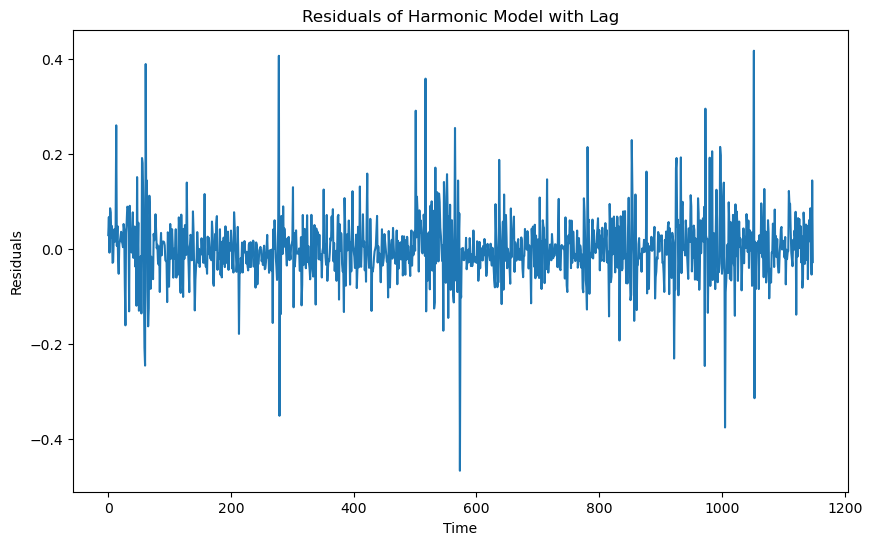

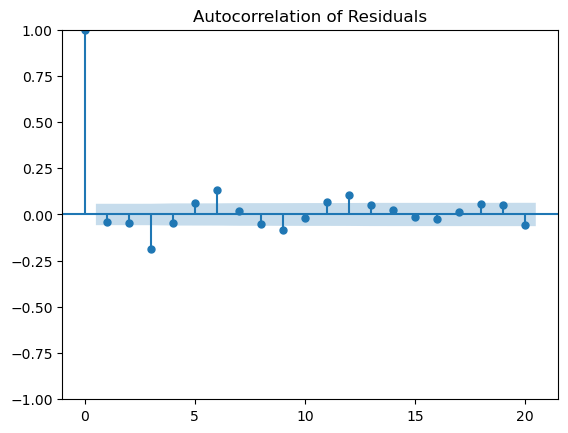

In [12]:
# Residuals
residuals = normalized_cases_lagged - harmonic_predictions_lagged
plt.figure(figsize=(10, 6))
plt.plot(t_lagged, residuals)
plt.title('Residuals of Harmonic Model with Lag')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# ACF of residuals
plot_acf(residuals, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()